# Sheet 7
Leonard Benkendorff, Dorothea Schwärzel, Sebastian Preuß

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

plt.rcParams["figure.autolayout"] = True # this fixes spacing for subplots :D

ModuleNotFoundError: No module named 'torch'

## 1 The logistic sigmoid
Exercise 1a
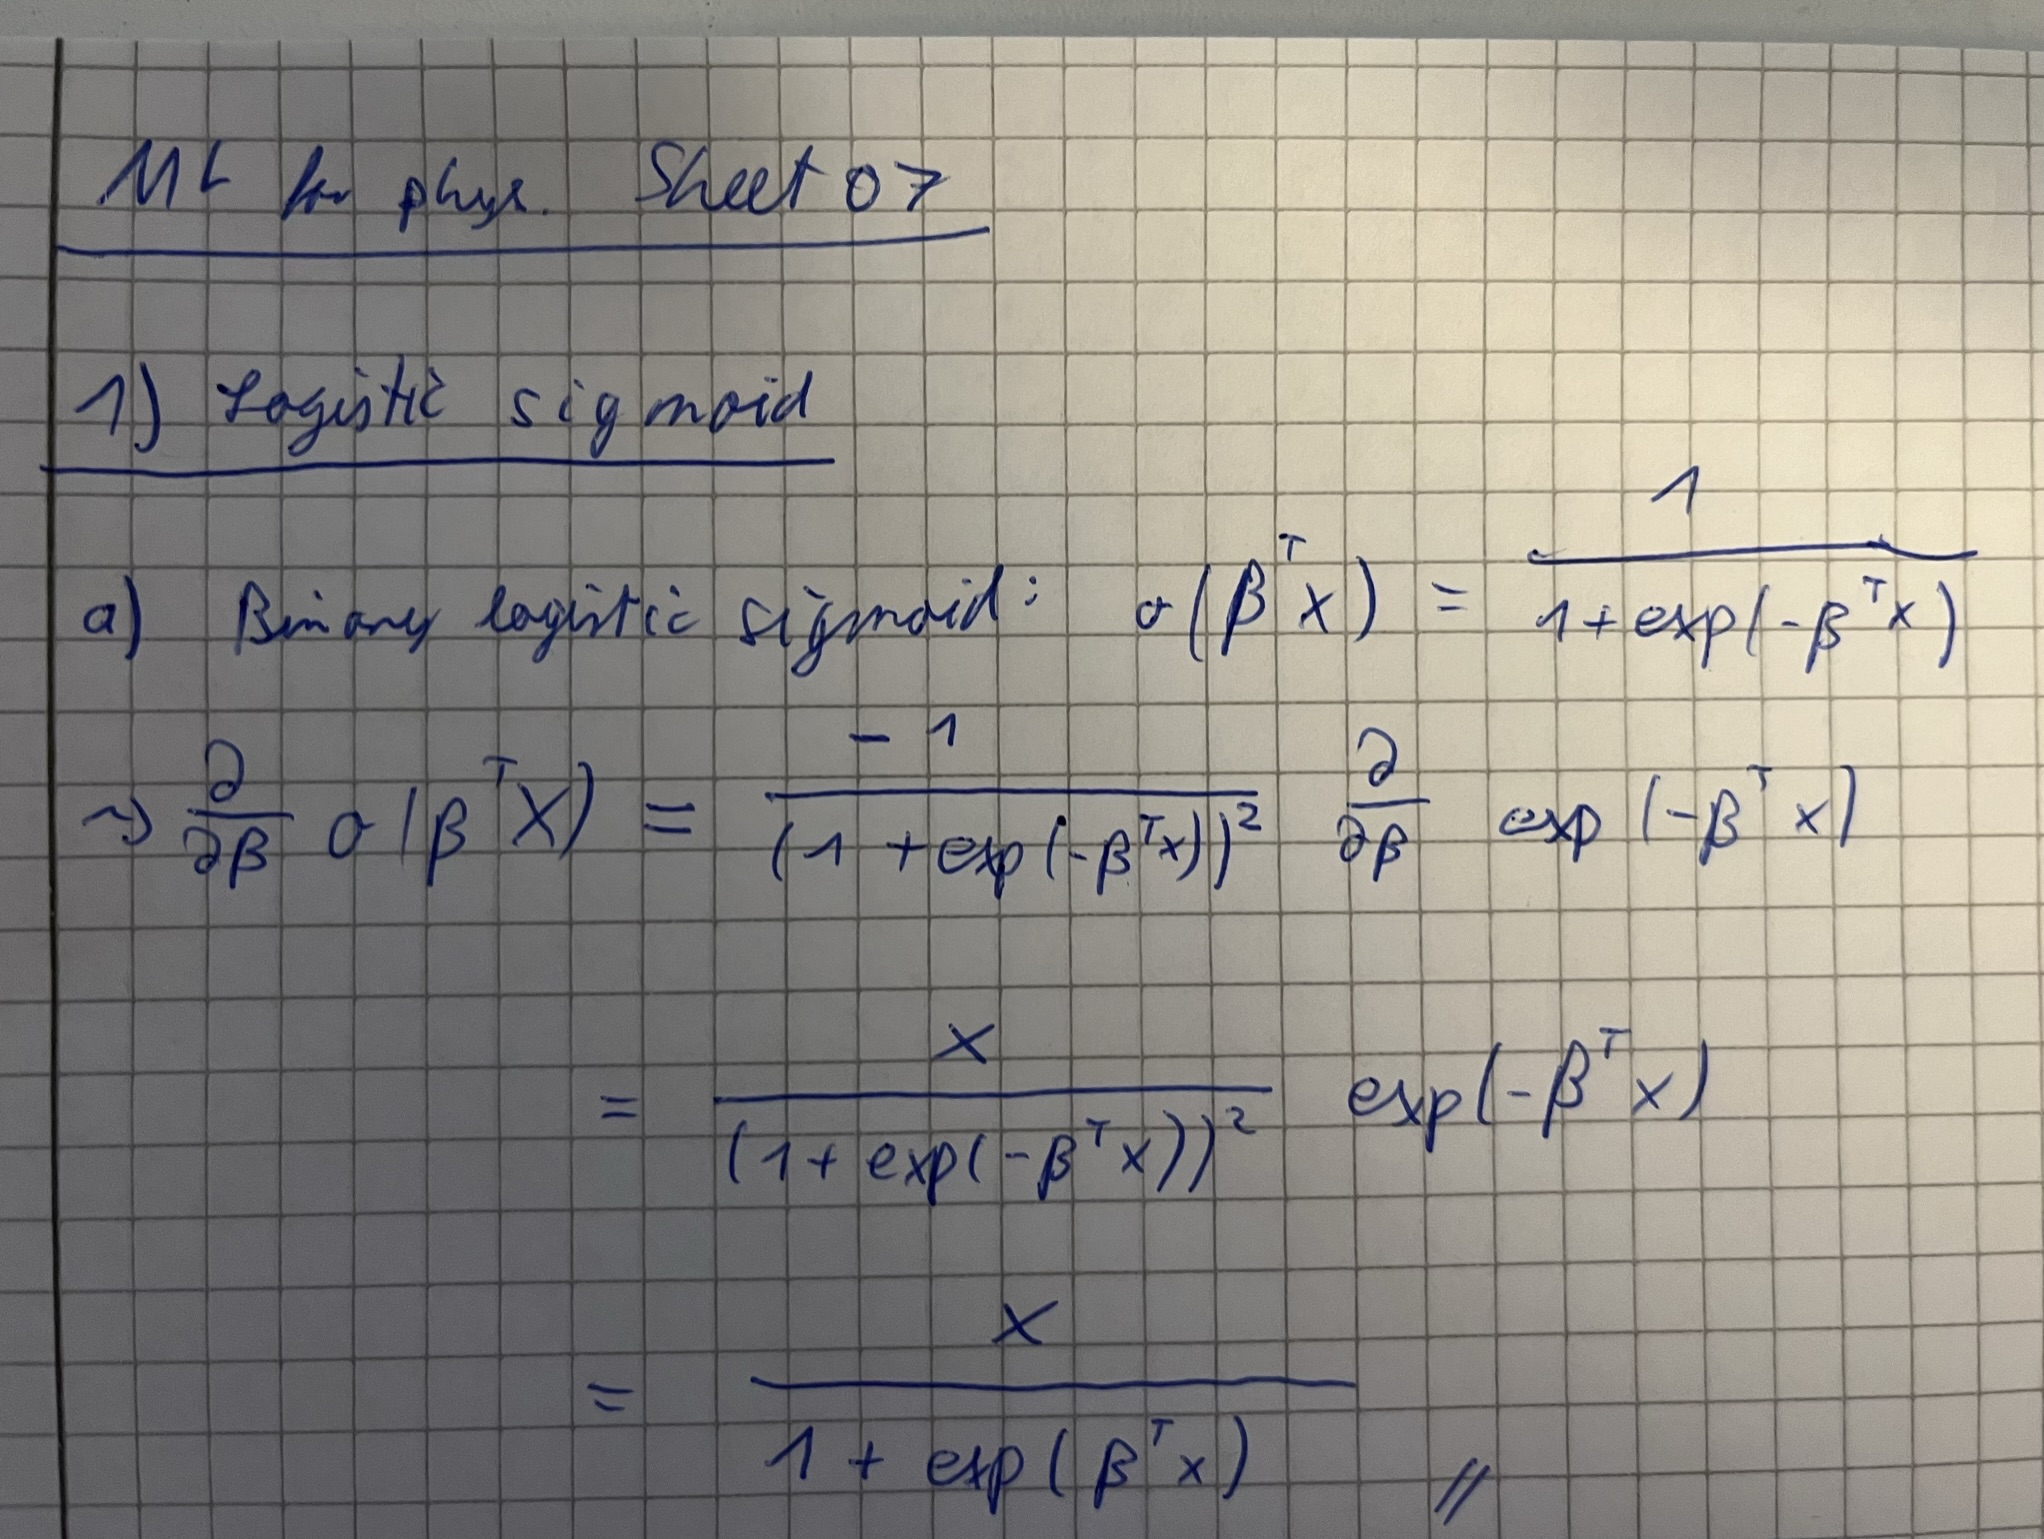

Exercise 1b

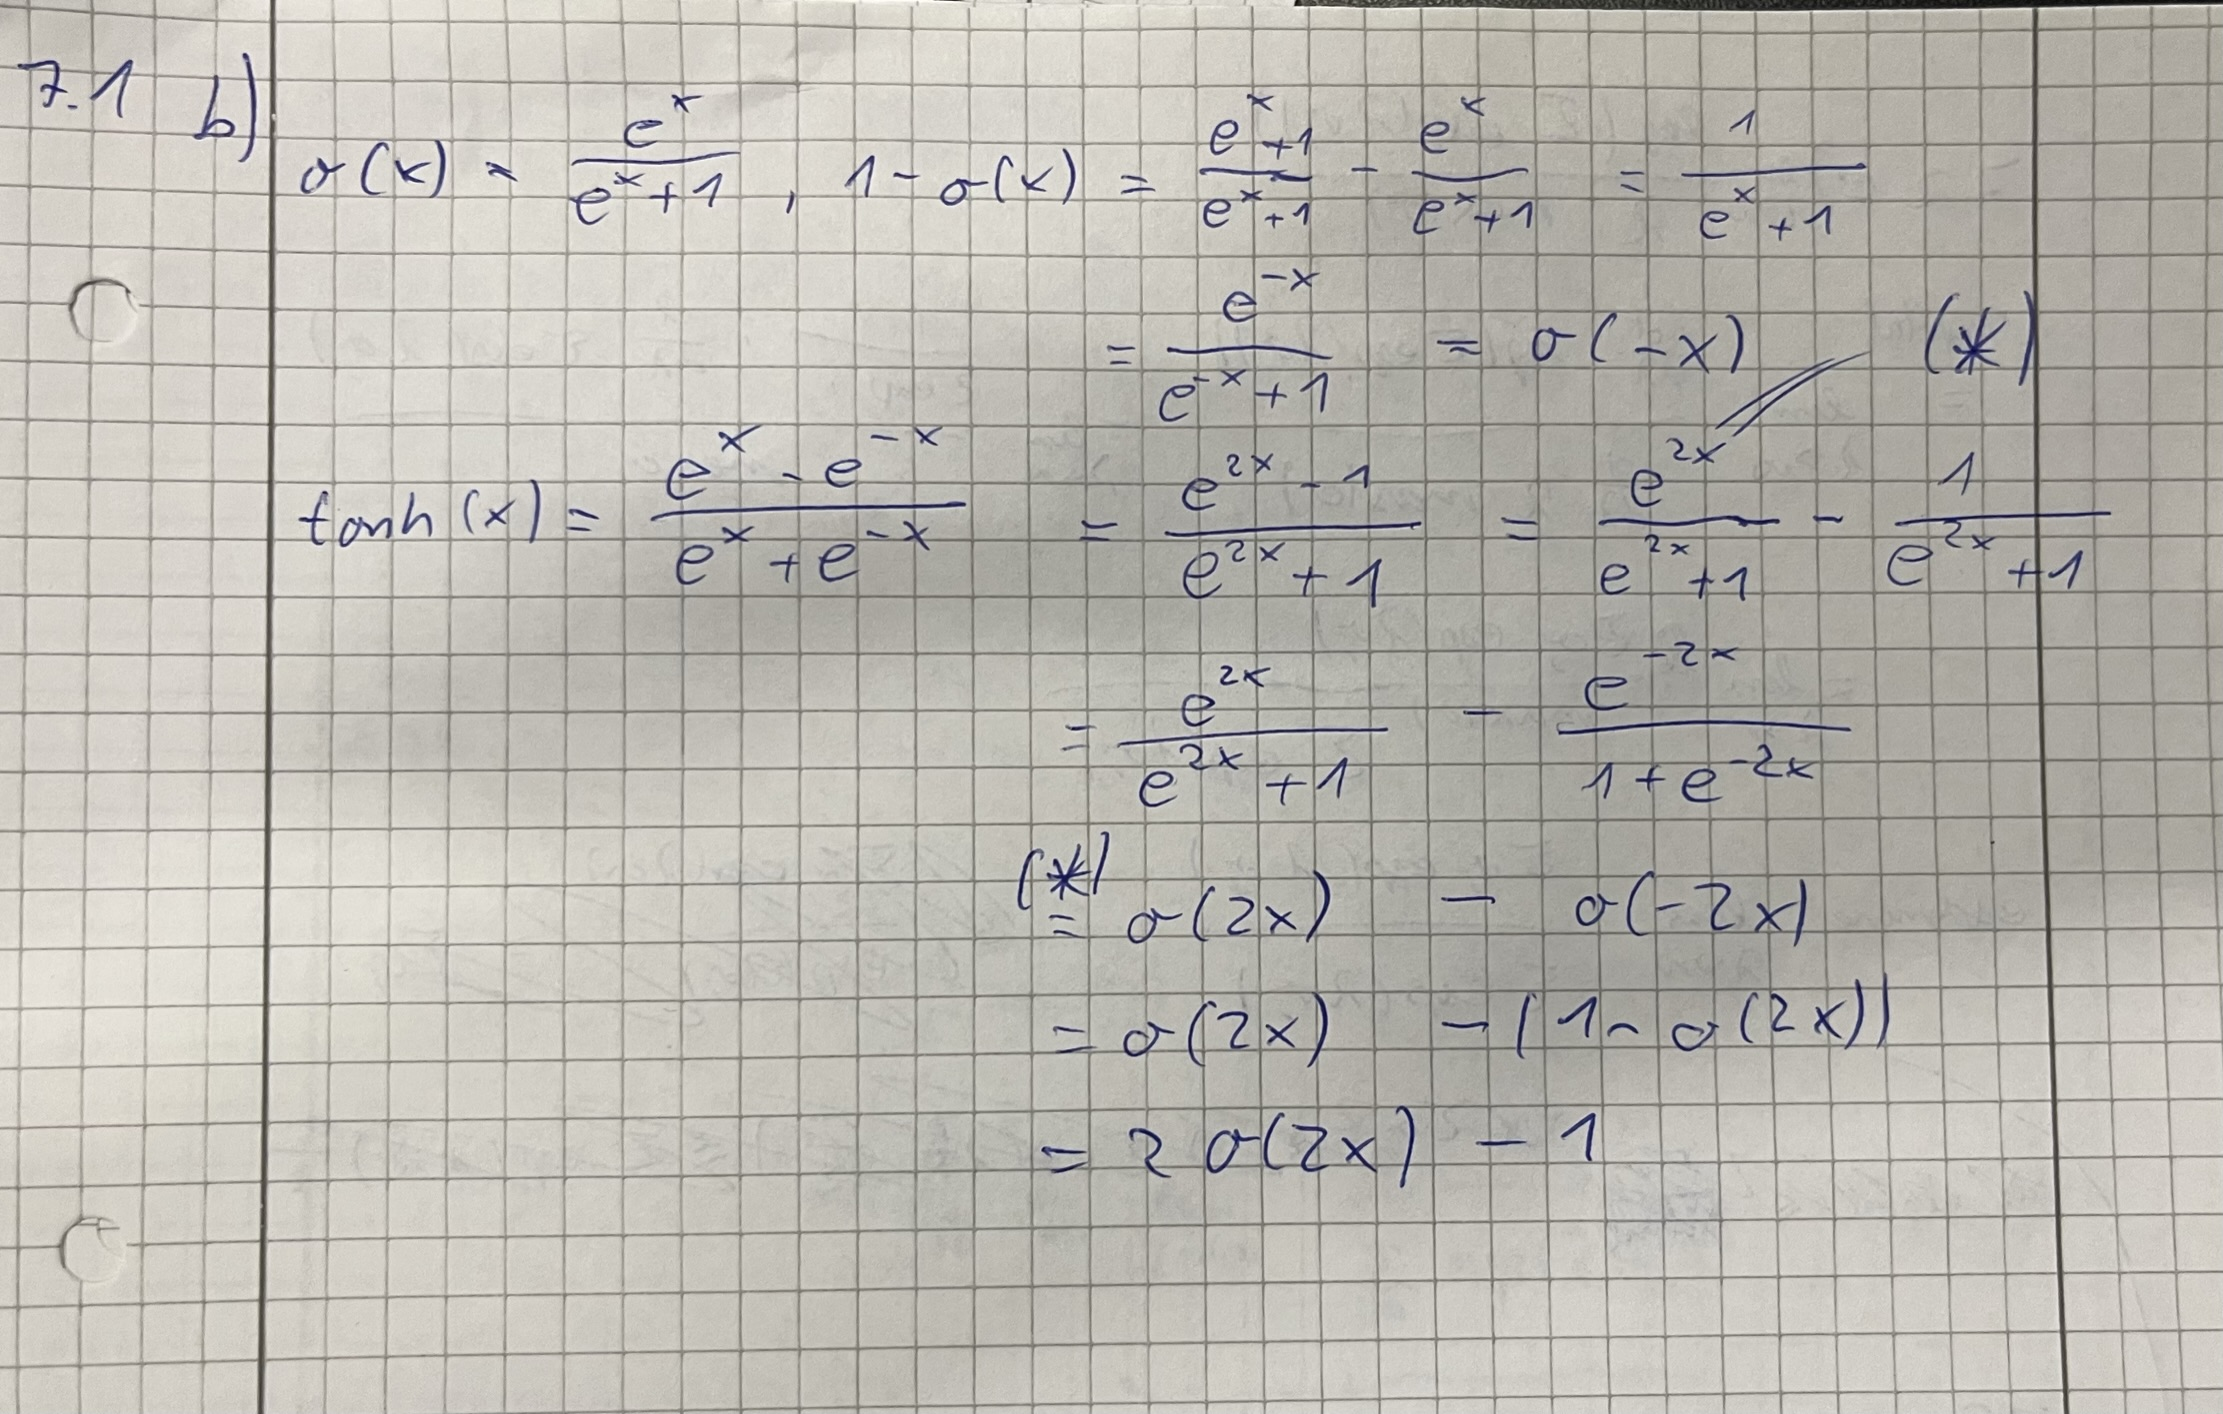

Exercise 1c

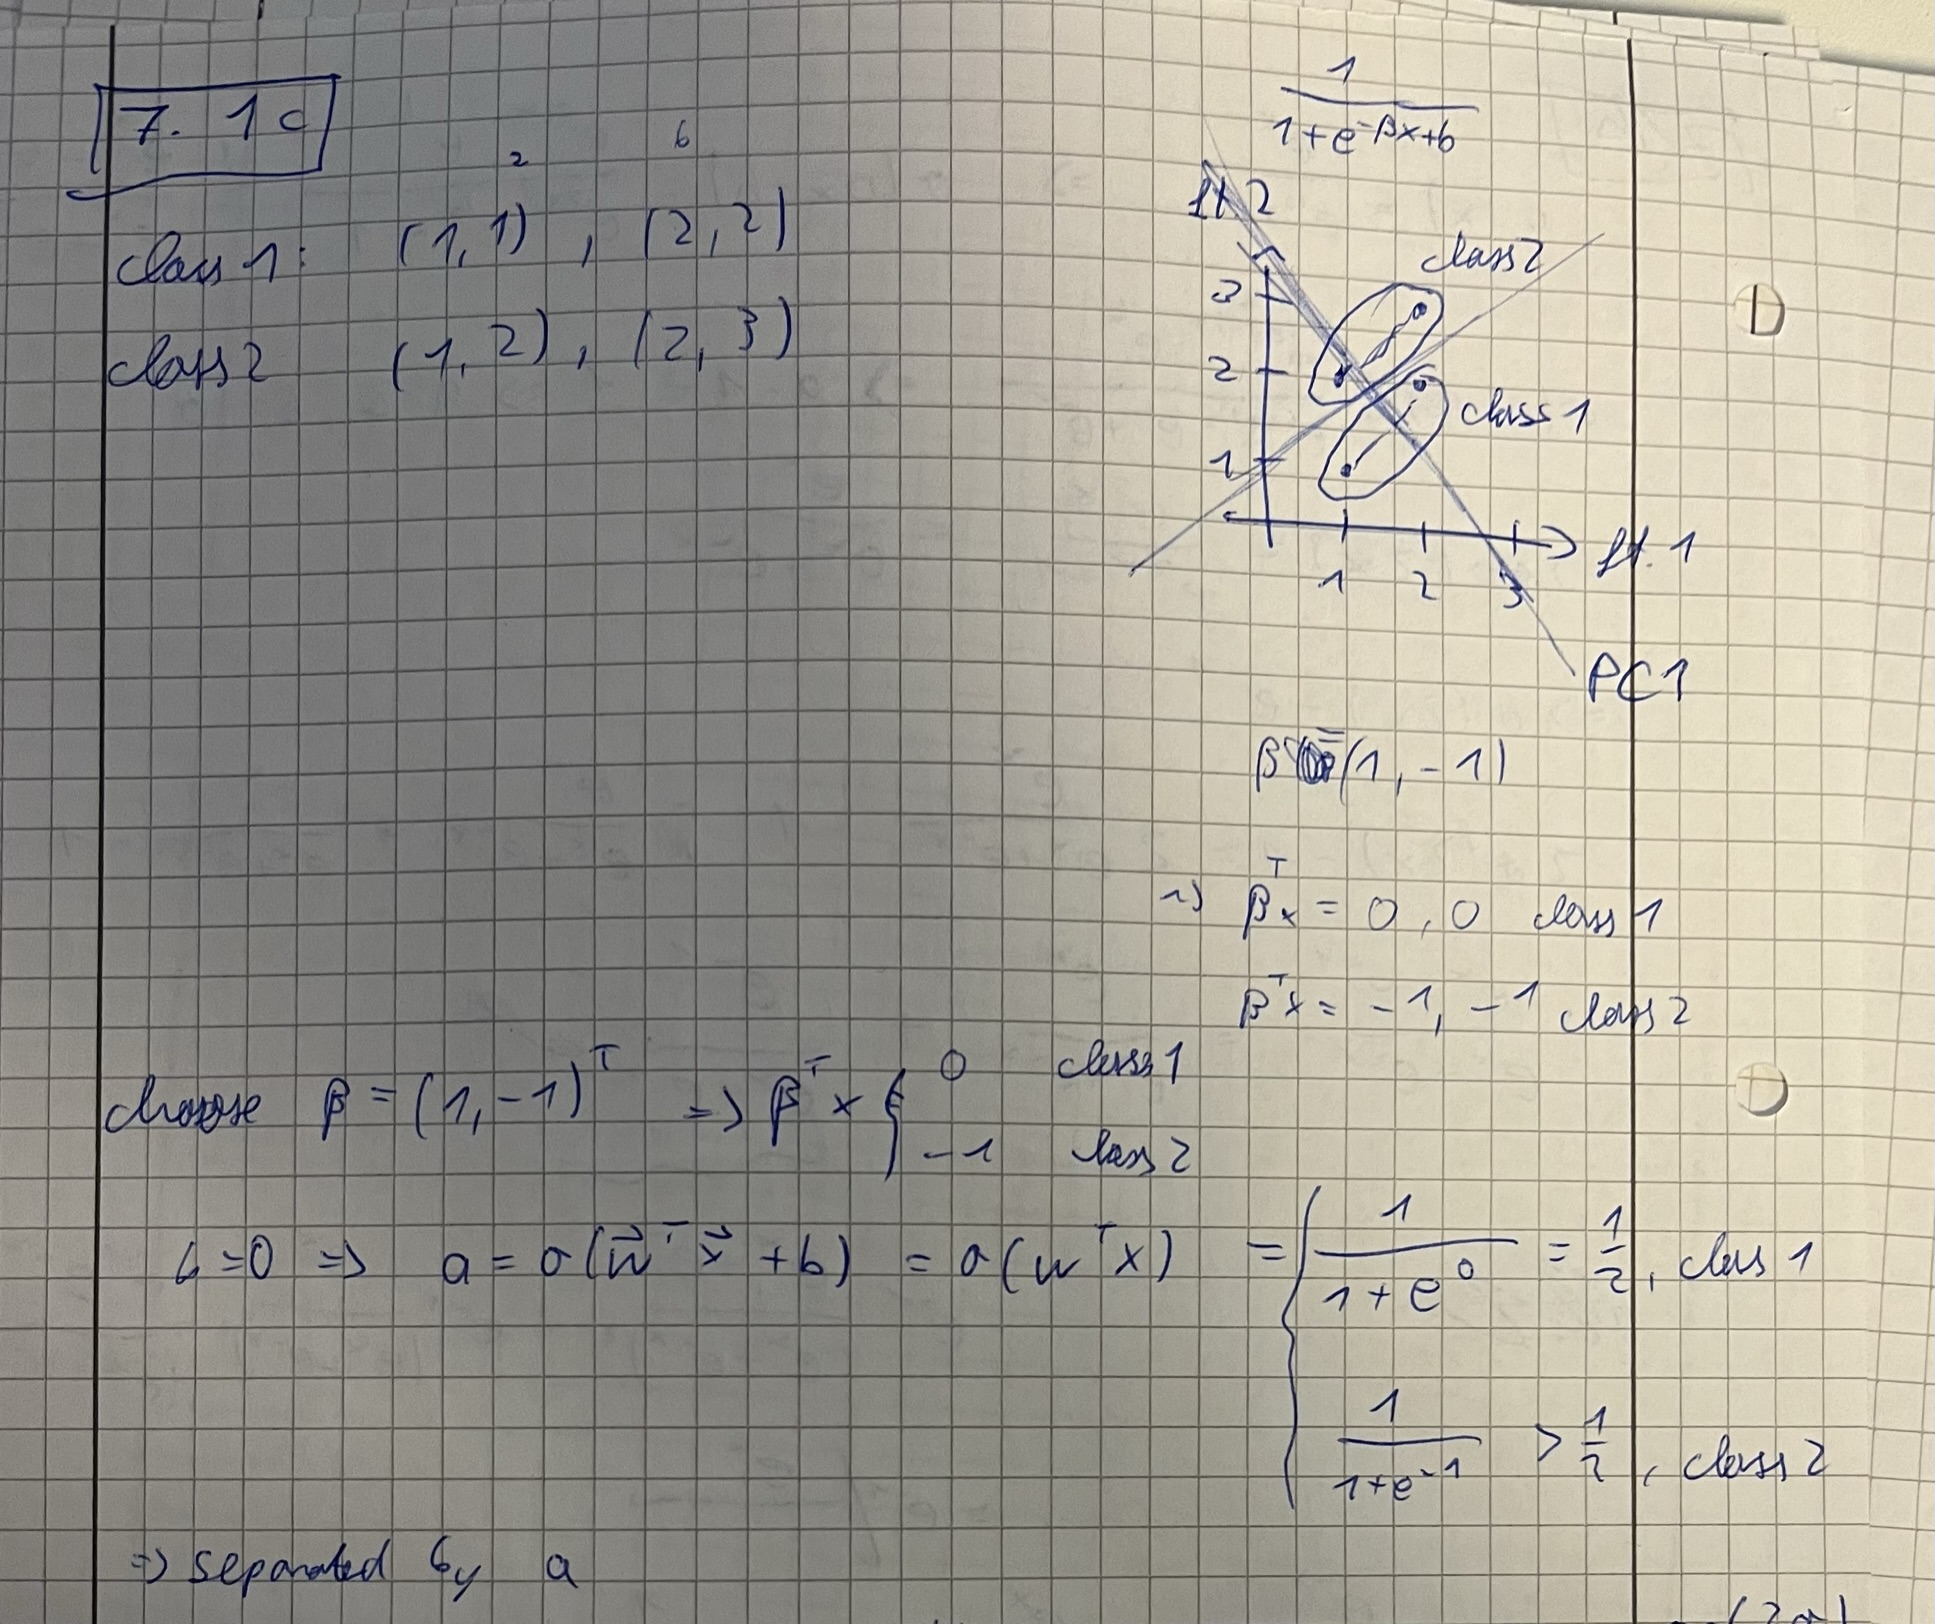

## 2 Log-sum-exp and soft(arg)max
a)

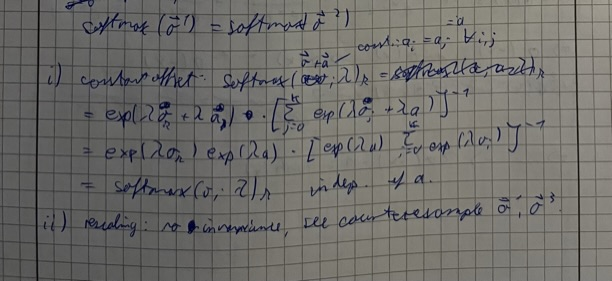

(b)

In [ ]:
def logsumexp(x, lamb=1):
    # TODO: implement the logsumexp
    return 1/lamb*np.log(np.sum(np.exp(lamb*x), axis=-1))

# TODO: set up a grid of points in [-1, 1] x [-1, 1]
sigma1 = np.linspace(-1,1,100)
sigma2 = np.linspace(-1,1,100)
sigma = np.stack(np.meshgrid(sigma1, sigma2), axis=-1)


# TODO: I recommend you set up a function to set up an Axes object with the correct x, y labels, 
#       equal aspect and maybe x and y ticks.

def set_up_axes(ax, title):
    ax.title.set_text(title)
    ax.set_xlabel(r'$\sigma_1$')
    ax.set_ylabel(r'$\sigma_2$')

# TODO: calculate and plot the functions as specified in the task
fig, axs = plt.subplots(2,2)
positions = [(0,0),(0,1),(1,0)]
for i, lam in enumerate([1,10,100]):
    #print(sigma.shape, logsumexp(sigma, lam).shape)
    im = axs[positions[i]].contourf(sigma1, sigma2, logsumexp(sigma,lam))
    plt.colorbar(im)
    set_up_axes(axs[positions[i]],f'Contour plot of lse($\sigma_1,\sigma_2;\lambda={lam})$')

im = axs[1,1].contourf(sigma1, sigma2, np.max(sigma, axis=-1))
plt.colorbar(im)
#plt.xlabel(r'$\sigma_1$')
#plt.ylabel(r'$\sigma_2$')
#plt.title(f'Contour plot of max($\sigma_1,\sigma_2)$')
#plt.colorbar()
set_up_axes(axs[1,1], f'Contour plot of max($\sigma_1,\sigma_2)$')
plt.show()

(c)

In [ ]:
def softmax(x, axis, lamb=1):
    # TODO: implement the softmax function. Axis should specify along which axis the sums should be computed.
    return np.exp(lamb*x)/np.sum(np.exp(lamb*x), axis=axis)

#print(np.sum(sigma,axis=0).shape)
def to_onehot(x):
    ret2=np.zeros(x.shape)
    ret2[np.where(x)] = 1
    ret1 = 1 - ret2
    ret = np.stack([ret1, ret2], axis=-1)
    return ret

xy = sigma
# TODO: compute the argmax of each gridpoint in one-hot form
onehot_argmax = to_onehot(np.argmax(xy, axis=-1))

# TODO: make the plots as specified on the sheet (nicest is in a grid which you can get using plt.subplots)

fig, axs = plt.subplots(2, 4, figsize=(17, 7))
for row in axs:
    for ax in row:
        set_up_axes(ax, '')
# plot the softmax
for col,lam in enumerate([1,10,100]):
    im = axs[0,col].imshow(softmax(sigma,1,lam)[:,:,0], extent=(-1,1,-1,1))
    plt.colorbar(im)
    axs[0,col].title.set_text(f'Component 1, $\lambda={lam}$')
    im = axs[1,col].imshow(softmax(sigma,0,lam)[:,:,1], extent=(-1,1,-1,1))
    axs[1,col].title.set_text(f'Component 2, $\lambda={lam}$')
    plt.colorbar(im)

# plot the onehot argmax
im = axs[0,3].imshow(onehot_argmax[:,:,0], extent=(-1,1,-1,1))
axs[0,3].title.set_text(r'Component 1 of argmax($\sigma$)')
plt.colorbar(im)
im = axs[1,3].imshow(onehot_argmax[:,:,1], extent=(-1,1,-1,1))
axs[1,3].title.set_text(r'Component 2 of argmax($\sigma$)')
plt.colorbar(im)
plt.suptitle('Comparison of components of soft(arg)max and argmax for $\sigma\in[-1,1]^2$')
plt.show()

Exercise 2d)

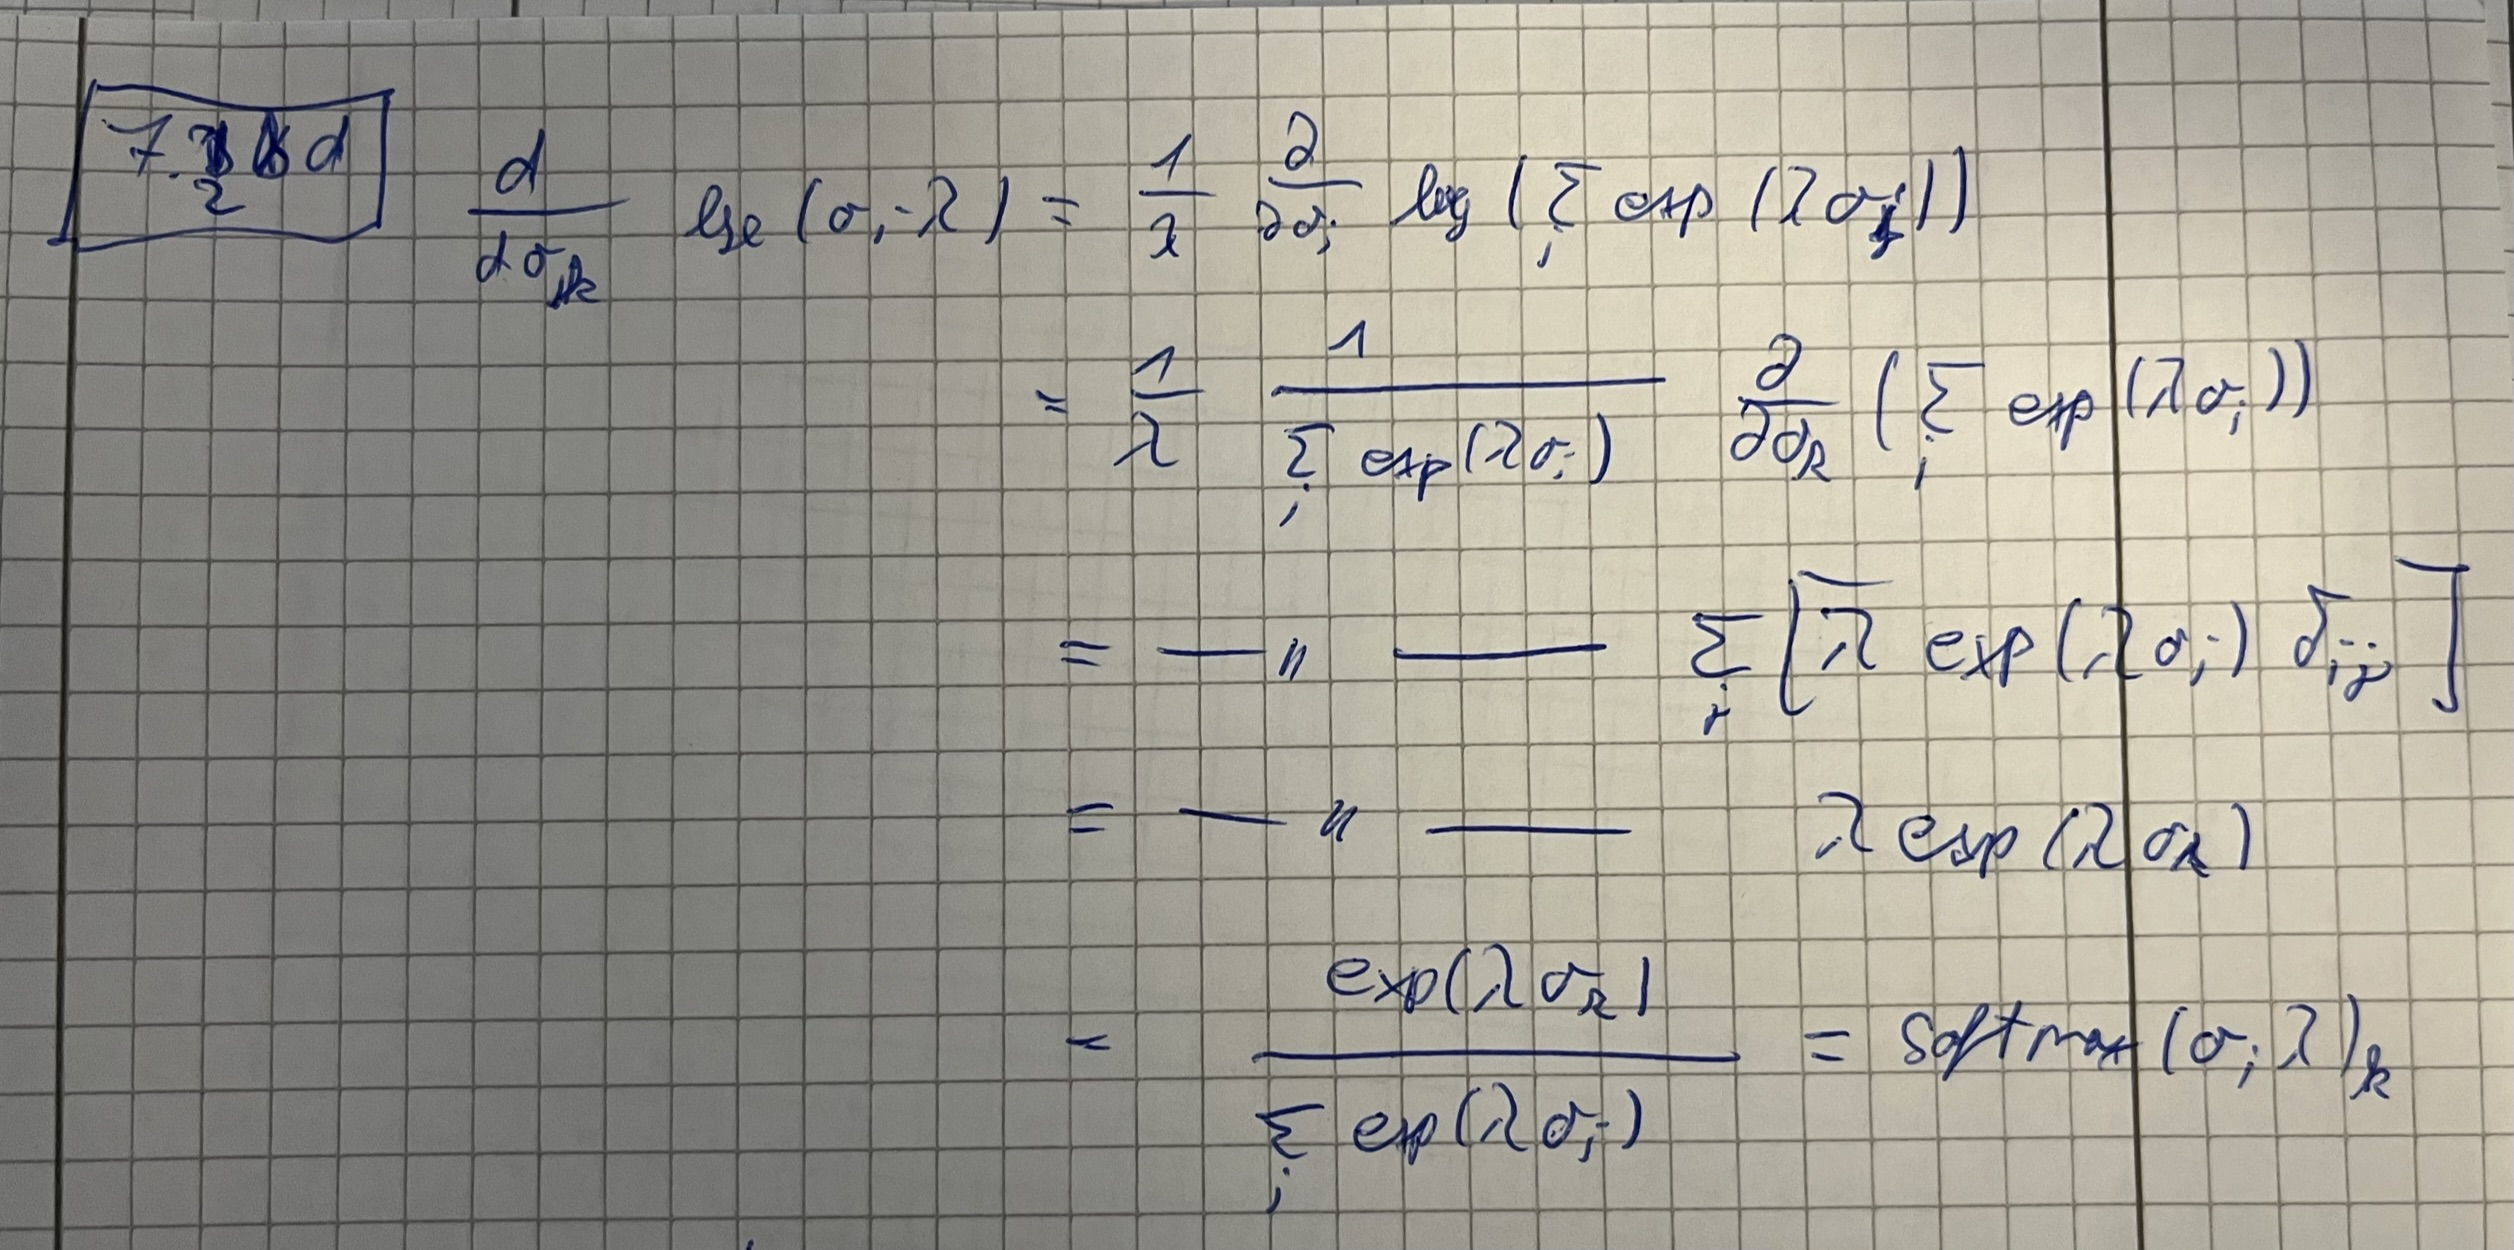

Exercise 2e)

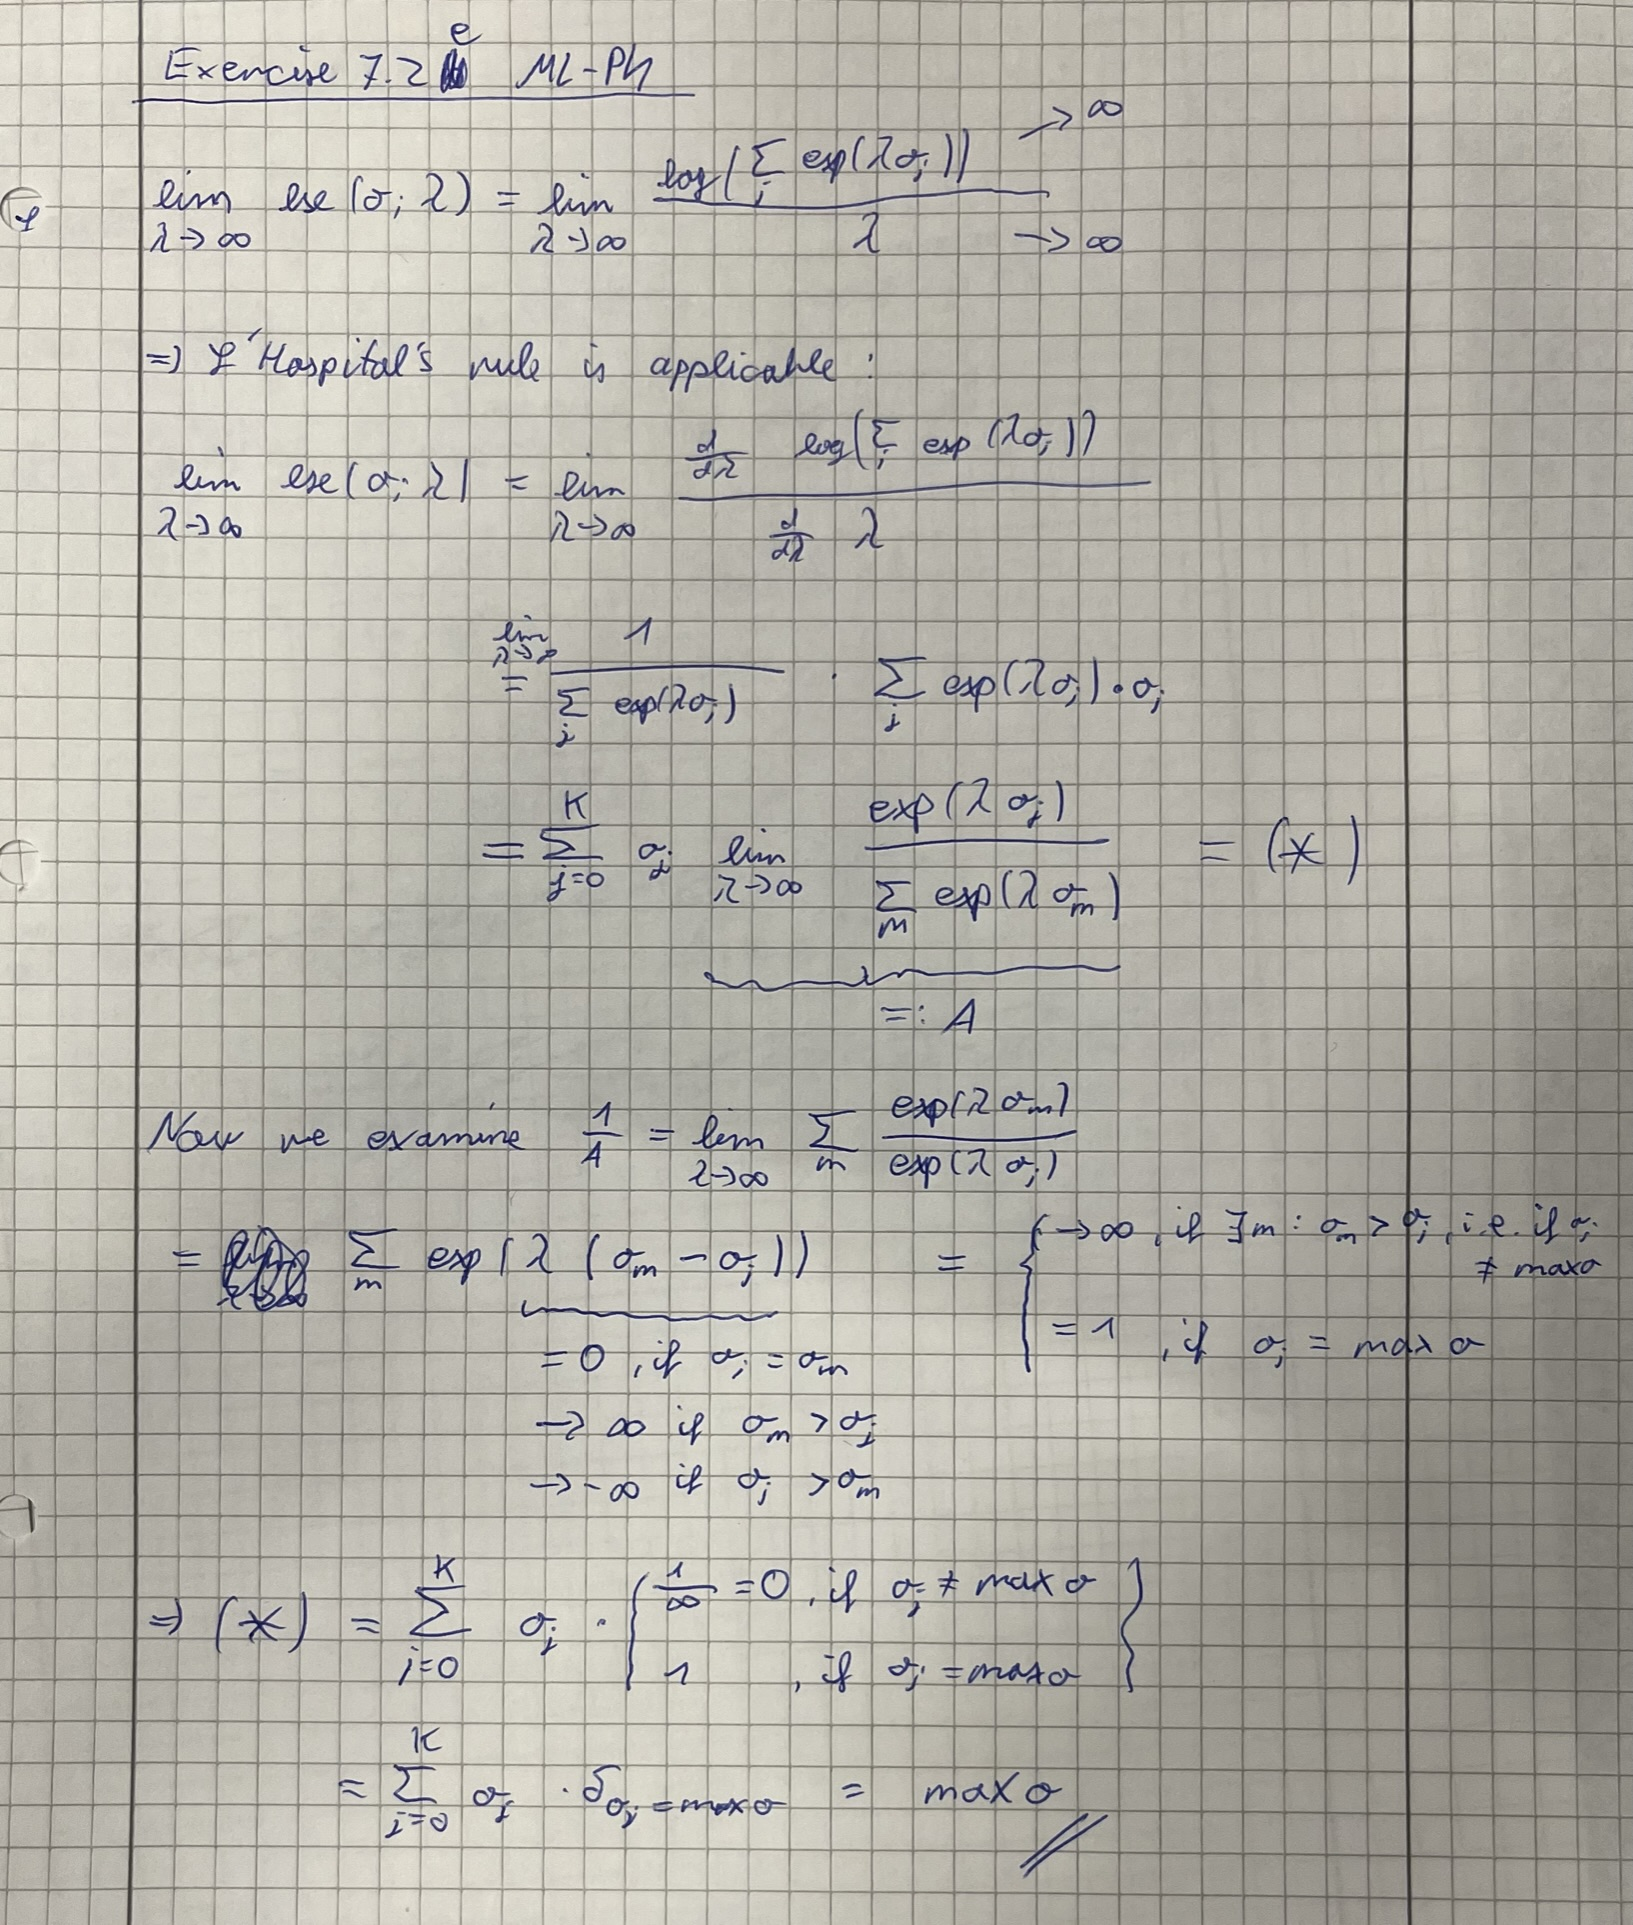

## 3 Linear regions of MLPs
(a)

In [ ]:
class Abs(nn.Module):
    """Absolute value activation function. You can experiment with this instead of ReLU."""
    def forward(self, x):
        return x.abs()

# define NN architecture.
class MLPShallow(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.input_size = input_size
        self.lin1 = nn.Linear(self.input_size, 20)
        self.linOutput = nn.Linear(20,1)
        #self.linOutput.bias = nn.Parameter(torch.tensor([4.]))
        # TODO: initialize Linear Layers and the activation as specified on the sheet
        
        
    def forward(self, x):
        x = self.lin1(x)
        x = F.relu(x)
        x = self.linOutput(x)
        return x
        # TODO: pass the input x through the layers and return the output
        
    def get_output_bias(self):
        return self.linOutput.bias.item()

**How many parameters does the model have?**

The model consists of one weight matrix $W_0$ of dimension $20\times 2$ and another weight matrix $W_H=W_1$ (transforming the output of the hidden layer to the output of the NN) of dimension ($20\times 1$) as well as two corresponding biases $b_0$ of dimension $20$ and $b_H=b_1$ of dimension $1$. Hence we have:
 - $40$ parameters from $W_0$,
 - $20$ parameters from $W_1$,
 - $20$ parameters from $b_0$ and
 - $1$ parameter from $b_1$,

i.e. in total we have $40+20+20+1=81$ parameters.

(b)

In [ ]:
def visualize_model(model, res=500, bound=5):
    # TODO: implement a function that takes the model (the MLP), and builds a 
    #       grid of points in [-bound, bound] x [-bound, bound], passes them 
    #       through the model and returns the result in the shape of an image
    # pytorch struggles with dtype=float, i.e. float64, hence use float32 and everything works
    # https://stackoverflow.com/q/74229178
    comp1 = np.random.uniform(low=-bound, high=bound, size=(res,res)).astype('float32')
    comp2 = np.random.uniform(low=-bound, high=bound, size=(res,res)).astype('float32')
    pts = np.stack([comp1,comp2], axis=-1)
    points = torch.from_numpy(pts)
    out = model(points)
    return out.detach().numpy()

def plot_model(model, res, bound):
    out = visualize_model(model, res, bound)
    print('Model output bias:', model.get_output_bias(), '; mean of output:', np.mean(out))
    plt.imshow(out)
    plt.colorbar()
    plt.show()

shallow_model = MLPShallow(2)
plot_model(shallow_model, 500, 10)
plot_model(shallow_model, 500, 100)
plot_model(shallow_model, 500, 1000)
# TODO: instantiate the model and make the visualizations as requested in the task
# NOTE: If you get a constant output, you got an unlucky initialization. Simply reinitialize the model.

There is no structure. The input is uniformly distributed, as are the entries of $W$. For low values of `bound`, we expect values to be close to the bias of the output node of the MLP, for larger values of `bound`, the input variance is quite high and so is the output variance.

(c)

In [ ]:
# TODO: compute the spatial gradient of the network outputs (as an image) from (b)
#       using np.gradient, and visualize using matplotlib's prism colormap
# np.squeeze turns (500,500,1)-dim array into one of shape (500,500)
out = np.squeeze(visualize_model(shallow_model, 500, 1000))
print(out.shape)
grad = np.gradient(out)

# TODO: calculate and plot the functions as specified in the task
fig, axs = plt.subplots(1,2)
for i in range(2):
    #print(sigma.shape, logsumexp(sigma, lam).shape)
    im = axs[i].imshow(grad[i], cmap='prism')
    plt.colorbar(im, shrink=.43)
    axs[i].title.set_text(f'Gradient of output, {i+1}. component')
plt.show()

Again, we observe just pure randomness and no apparent structure.

(d)

In [ ]:
# define NN architecture.
class MLPDeep(nn.Module):
    def __init__(self, input_size, n_layers):
        super().__init__()
        # TODO: initialize Linear Layers and the activation as specified on the sheet
        self.input_size = input_size
        self.n_layers = n_layers
        self.LinLayers = []
        for i in range(n_layers):
            self.LinLayers.append(nn.Linear(input_size if i == 0 else 5, 5))
        self.LinOutput = nn.Linear(5,1)
        #self.LinOutput.bias = nn.Parameter(torch.tensor([4.]))
        
        
    def forward(self, x):
        # TODO: pass the input x through the layers and return the output
        for i in range(self.n_layers):
            x = self.LinLayers[i](x)
            x = F.relu(x)
        x = self.LinOutput(x)
        return x
    
    def get_output_bias(self):
        return self.LinOutput.bias.item()

# TODO: repeat the visualizations from above
deep_model = MLPDeep(2, 4)
plot_model(deep_model, 500, 10)
plot_model(deep_model, 500, Test100)
plot_model(deep_model, 500, 1000)

We observe that the output variance is now much much lower than in the case before, where we had just one hidden layer.

The dependence on the output bias can be seen if we explicitly set it:

In [ ]:
deep_model.LinOutput.bias = nn.Parameter(torch.tensor([4.]))

plot_model(deep_model, 500, 10)
plot_model(deep_model, 500, 100)
plot_model(deep_model, 500, 1000)